In [1]:
import requests
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200  

In [2]:
proposal_ids = {'eco':"0xb915f1372412ebae1201037d962968f6bae4b15d803a6d3f492ca7e720d74b6d",
               'pg':'0xb4e1e83c0a239423d364a615c25418da7ccc59a73a705e74cf78f2ade43b7c6d'}
endpoint = "https://hub.snapshot.org/graphql"

In [3]:
def fetch_graphql_data(endpoint, query, headers=None):
    response = requests.get(endpoint, json={'query': query})
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
        return None

In [4]:
def get_data(wg):
    choice_query = f"""
    query {{
        proposal(id: "{proposal_ids[wg]}") {{
            votes
            choices
            scores
        }}
    }}
    """

    results_query = f"""
    query {{
        votes(first: 1000, where: {{ proposal: "{proposal_ids[wg]}" }}) {{
            voter
            vp
            choice
        }}
    }}
    """
    
    #get data from snapshot
    
    choice_data = fetch_graphql_data(endpoint, choice_query)
    results_data = fetch_graphql_data(endpoint, results_query)

    return choice_data, results_data

In [5]:
def format_dataframe(df):
    # Custom styles
    styles = {
        # Left-align index
        'selector': 'th',
        'props': [('text-align', 'left')]
    }
    
    # Format 'Total Votes' and apply styles
    return (df.style
            .format({'Total Votes': "{:,.0f}"})
            .set_table_styles([styles]))

In [6]:
def round_report(wg='eco'):
    choice_data, results_data = get_data(wg)

    voters_df = pd.DataFrame(results_data['data']['votes'])
    voters_df = pd.json_normalize(voters_df.to_dict('records'))

    #how many projects did each voter vote for?
    voters_df['projects_voted_for'] = voters_df.choice.apply(lambda x: len(x))

    projects_df = pd.DataFrame({"Project":choice_data['data']['proposal']['choices']
                    ,"Votes":choice_data['data']['proposal']['scores']
                    ,"Voter Count": np.array(choice_data['data']['proposal']['scores'])/100})

    projects_df['Project'] = projects_df.Project.str.split(' - ',n=1).str[1]
    projects_df.set_index('Project',inplace=True)
    projects_df = projects_df.sort_values('Votes',ascending=False)

    voters_df['vote_category'] = voters_df['projects_voted_for'].apply(lambda x: '9+' if x >= 9 else str(x))
    voters_df = voters_df.groupby('vote_category').count().iloc[:, [0]]

    voters_df.index.name = 'Projects Voted For'
    voters_df = voters_df.rename(columns={voters_df.columns[0]: 'Voters'})
    voters_df["%"] = voters_df["Voters"]/sum(voters_df["Voters"])
    voters_df.loc['Total'] = voters_df.sum()
    return voters_df,projects_df

In [7]:
def voter_graph(df):
    plot_title = 'How many projects did the voters vote for?'

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = df.plot.barh(x='Index', y='Value', legend=False, ax=ax)

    plt.xlabel('Voters')
    plt.ylabel('Projects Voted For')
    plt.title(plot_title)

    # Add value labels to the bars
    ax.bar_label(bars.containers[0], padding=5)

    plt.tight_layout()
    plt.show()

In [8]:
def html_projects(df,title="hi"):

    style = f"""
    <style>
        th, td {{
            text-align: left;
            font-size: 16px;  
        }}
    </style>
    <h1>{title}</h1>
    """

    # Display the styled DataFrame
    html = style + df.style.format({'Votes': '{:,.0f}', 'Voter Count': '{:,.0f}'}).set_properties(**{'text-align': 'right'}, subset=['Voter Count']).to_html()
    display(HTML(html))

,Votes,Voter Count
Project,,
Giveth - Building the Future of Giving,"5,100",51
Dappnode,"4,400",44
LikeButton.eth,"4,100",41
rotki,"4,100",41
Commons Stack,"3,100",31
"Pairwise: Simplifying Choices, Amplifying Voices","3,100",31
dm3 - the web3 messaging interoperability protocol,"2,900",29
MetaGame,"2,400",24
Regen Score,"2,300",23


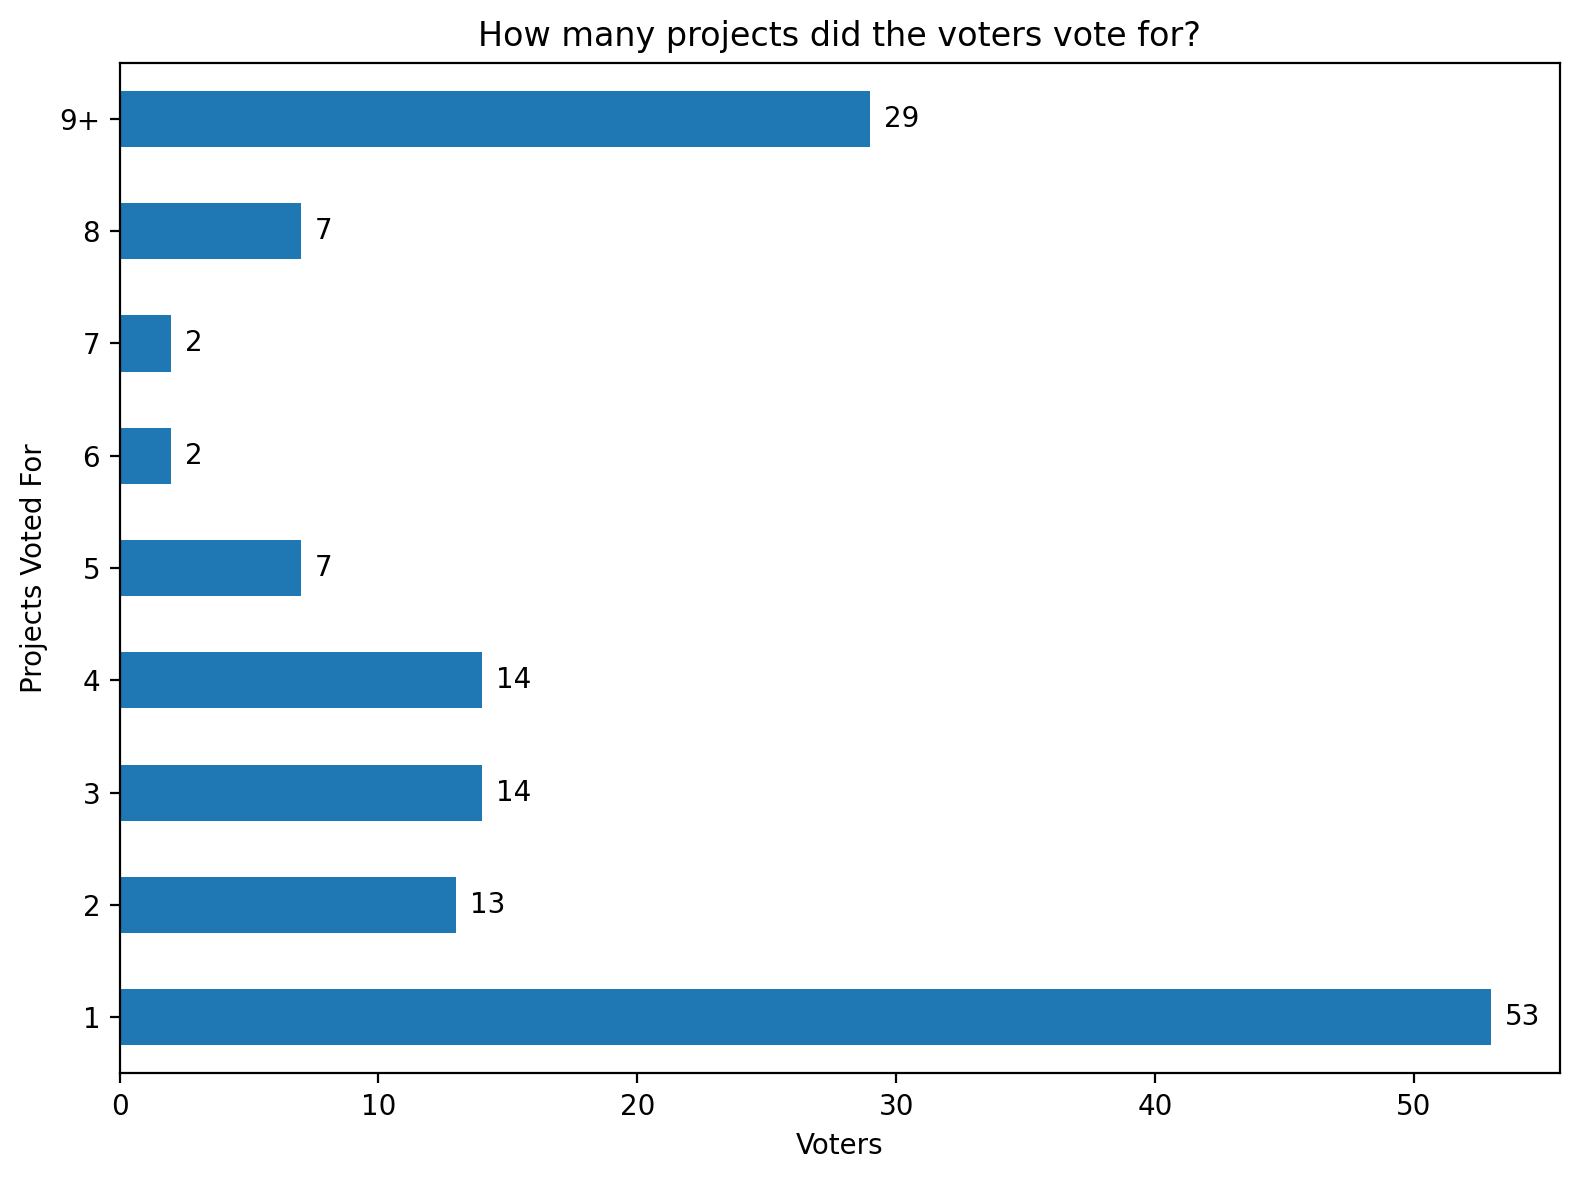

In [9]:
voters,projects = round_report('pg')
html_projects(projects,"Public Goods")
voter_graph(voters['Voters'][:-1])


,Votes,Voter Count
Project,,
1W3 - decentralised websites for your ENS,"4,000",40
NameSys: Off-Chain Infrastructure for ENS/Ethereum,"3,200",32
L2 ENS Subnames + ERC-4337,"3,000",30
Namespace Widget for selling Subnames,"3,000",30
Raffy's ENS Tools,"3,000",30
HEAVENS TOOLS,"2,800",28
ENS Wayback Machine,"2,800",28
HANDLE.ETH - FREE SUBDOMAINS REGISTRY,"2,300",23
ENS Poker,"2,200",22


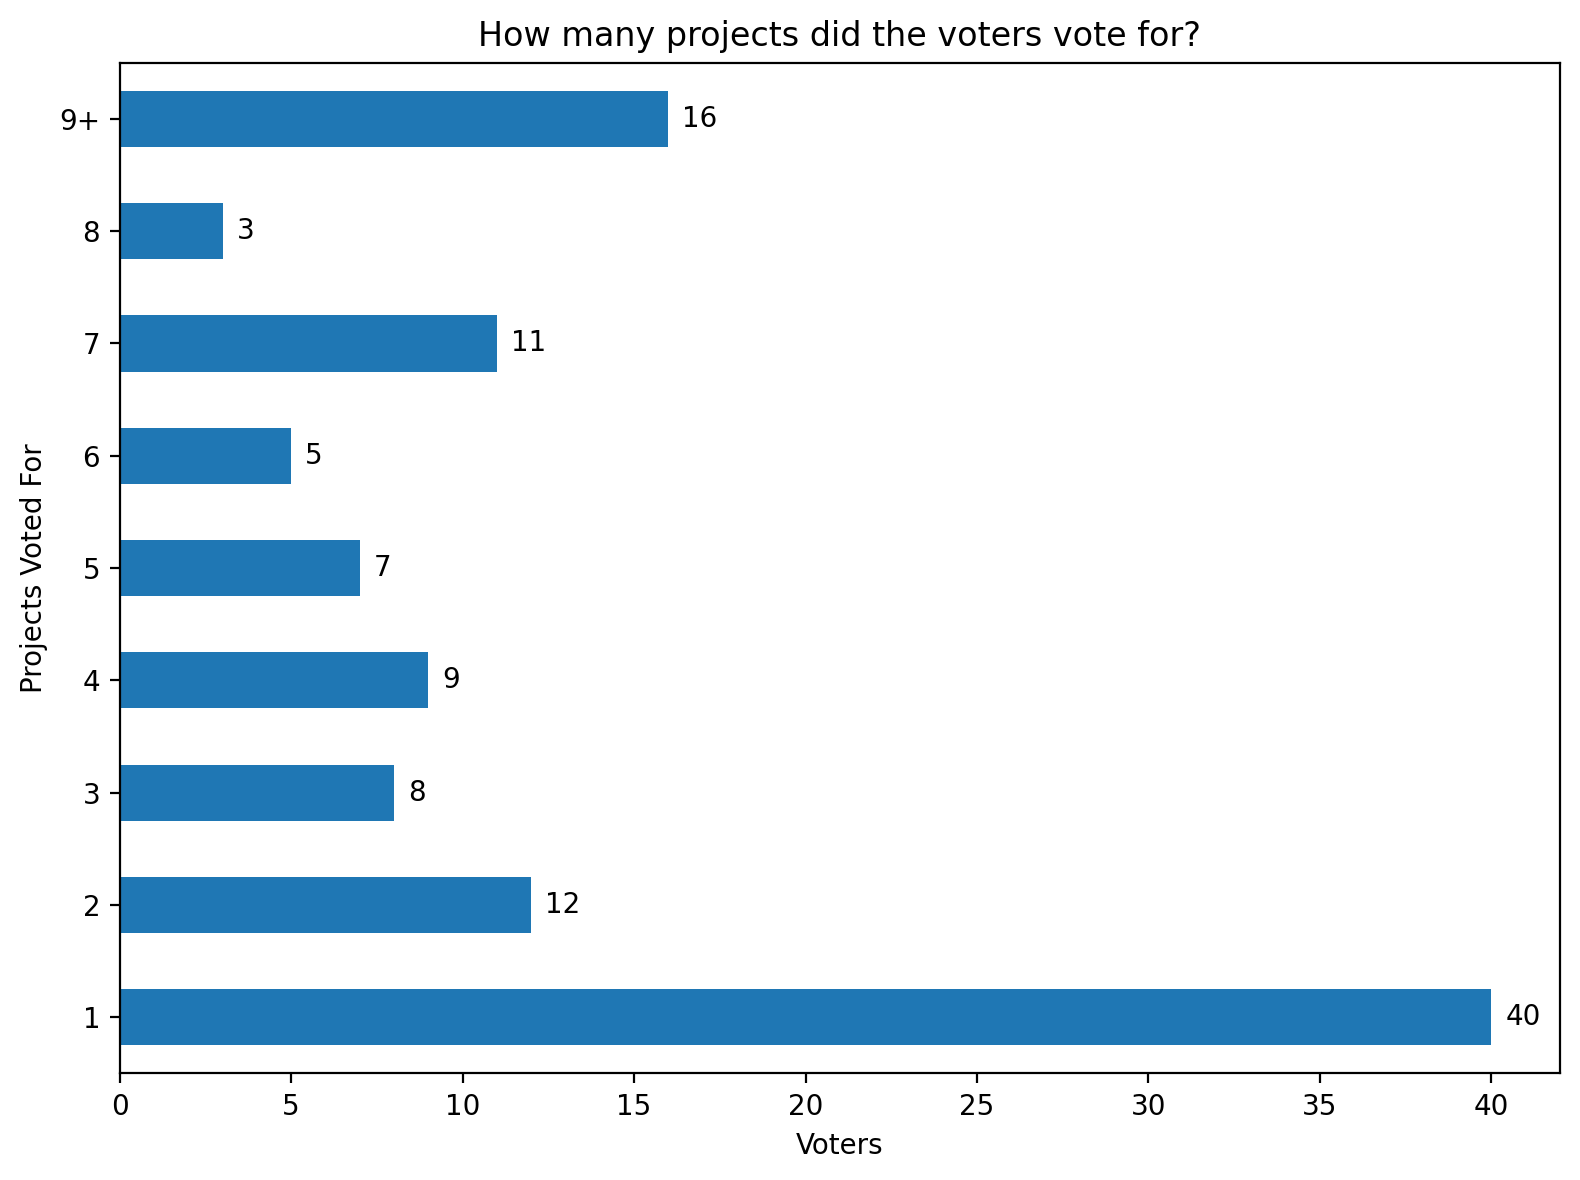

In [10]:
voters,projects = round_report('eco')
html_projects(projects,"Ecosystem")
voter_graph(voters['Voters'][:-1])
